<img src="./auxdata/eurac_EO.png" alt="EURAC Institute for Earth Observation" title="EURAC Institute for Earth Observation" width="300"/>

In this notebook we will use openEO to retrieve a timeseries of cloud free Sentinel-2 data given a point with it's coordinates.

In [1]:
import openeo
from openeo.processes import eq, array_element, or_
import xarray as xr

Connect to the EURAC openEO back-end

In [2]:
euracEndpoint = "https://openeo.eurac.edu"
conn = openeo.connect(euracEndpoint).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


Set the temporal extent we want to consider

In [3]:
temporal_extent = ["2018-01-01","2019-01-01"]

Set the point coordinates

In [4]:
point_coords = [46.187317942782414, 11.149706840515137]

Set the spatial extent to use in load_collection: we apply a little buffer to the point coordinates.

In [5]:
spatial_extent = {'west':point_coords[1],'east':point_coords[1],'north':point_coords[0],'south':point_coords[0]}

In [6]:
spatial_extent_buff = {'west':point_coords[1]-0.01,'east':point_coords[1]+0.01,'north':point_coords[0]+0.01,'south':point_coords[0]-0.01}

Set the collection name for the Sentinel-2 data

In [7]:
S2_collection = 'S2_L2A_ALPS'

Set the bands we want to load

In [8]:
bands = ['B02_10m','B03_10m','B04_10m']

Load the S2 data:

In [9]:
S2_data = conn.load_collection(S2_collection,temporal_extent=temporal_extent,spatial_extent=spatial_extent,bands=bands)

We need to mask out the cloudy pixels. We can use the FMASK for this:

In [10]:
cloud_mask = conn.load_collection('S2_L1C_T32TPS',temporal_extent=temporal_extent,bands=['FMASK']).filter_bbox(spatial_extent_buff)
cloud_mask_bool = cloud_mask.resample_cube_temporal(S2_data).reduce_dimension(dimension="bands",reducer = lambda value: or_(eq(array_element(value,0),2),eq(array_element(value,0),4)))

Apply the mask to the S2 data

In [11]:
S2_data_masked = S2_data.mask(cloud_mask_bool,replacement=0)

Download the result

In [12]:
S2_data_masked.download('S2_data_masked_FMASK.nc')

Open the result

In [13]:
data = xr.open_dataarray('S2_data_masked_FMASK.nc')
data

<xarray.DataArray 'stack-a862c03a9dc736780b0bd4a7cc14242b' (variable: 3,
                                                            time: 98, y: 1, x: 1)>
array([[[[251.]],

        ...,

        [[662.]]],


       ...,


       [[[146.]],

        ...,

        [[800.]]]])
Coordinates:
  * y            (y) float64 5.117e+06
  * x            (x) float64 6.659e+05
  * time         (time) datetime64[ns] 2018-01-02T10:24:20.462000 ... 2018-12...
  * variable     (variable) object 'B02_10m' 'B03_10m' 'B04_10m'
    spatial_ref  int64 ...
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

There are many different ways of visualizing the results. Some examples can be found here for XArray: https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html

See also the Matplotlib documentation https://matplotlib.org

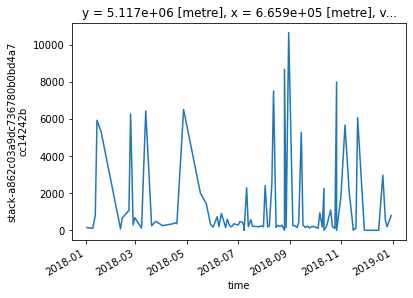

In [14]:
B04 = data.loc[dict(variable='B04_10m')]
B04.plot()